In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import glob

# <b>Electrostatic Probe</b>
The best tutorial for electrostatic probe in my personal view is Francis F. Chen's Langmuir Probe Diagnostics. It is downloadable if we search on google.  

The electrostatic probe on TS6 was originally developed by Aoyama, as described in his 2020 master thesis. The main purpose is to measure the 2D electric potential in order to obtain the static electric field. In hardware, our ES probe is 21 channel wires stretching along the Z direction, then connected to some Op-Amps(operation amplifiers) and oscillators.   

By assuming reproducibility on TS6 (which is usually not true), we <b><u>scan</b></u> the wires at different R positions to get the <b><u>2 dimensional</b></u> floating potential during magnetic reconnection.

Yes! We measure the <b>floating potential</b> instead of the plasma space potential!!!! But we don't have to worry too much because the floating potential is just the space potential adding some modification term of electron temperature and electron density[refer to any reference]. Since we already know that in magnetic reconnection, electron temperature and electron density are almost constant except for the current sheet[1], the gradient of floating potential is okay to be regraded as identical to the gradient of plasma gradient potential, which is the static electric field, so that our goal is achieved!!!!  

Because the floating potential is just the raw data as recorded by the ES probes, the thing is now just super simple in terms of processing. 

[1] Guo Xuehan, Localized electron heating by strong guide-field magnetic reconnection, 2015, Physics of Plasma, vol. 22, iss. 10, 101201.

## <b>Physical constants</b>
During merging experiments, we scan the ES probe, which stretch along Z direction, at different R points to recover the 2D electrostatic floating potential field. Few things that will be frequently used here are:  
1. The Z postions of the ES probe. But not all of them are alive, we need another alive channel number to keep in record.
2. The R postion of each shot, which is recorded in the TS6 experiment log, which can be read via pandas online.
   
The following two cells of code below will give the <b><u>Z positions and alive channel number</u></b>, and <b><u>the TS6 experiment log</u></b>, respectively.


In [21]:
# the Z postions of ES probes
Z = (np.arange(1, 22) - 11) * 15

# the alive channel number
# during the 240829 series experiments, some ES channels were dead.
# We make the alive channels to 1~14
alive_channels = np.arange(1, 14)

In [22]:
# the sheet id for TS6 experiment log
sheet_id = '1wG5fBaiQ7-jOzOI-2pkPAeV6SDiHc_LrOdcbWlvhHBw'
url = f'https://docs.google.com/spreadsheets/d/%s/export?format=csv' %sheet_id

exp_log = pd.read_csv(url)
exp_log['date'] = exp_log['date'].ffill()

## <b>File processing functions</b>
In almost all cases in life, data is saved in some fiels in a way that can never be directly analyzable...   
In almost all cases in life, we have to process the files in some according ways to convert them to something that can be analyzable... which may take us so much more time than to analyze them...  

For ES probe, the data is stored in the NIFS server in a csv file. The data is the raw value measured by the ES probe, which is just the floating potential of our plasma. What is worse is that there exists some extremely annoying periodical noise... 

But keep in mind that what we want is <b><u>a function that returns us the potential of all alive channels at a certain time of a shot in a certain date.</b></u>

In [4]:
def file_path(date, shot_in_the_date):
    '''
    file = file_path(date, shot_in_the_date)
    
    this function return the file path of the file which was taken on 'date' with shot number being 'shot_in_the_date'
    
    input
    -----
    date: the date when the data is taken
    shot_in_the_date: the shot number within the date
    '''
    return glob.glob('/mnt/nifs/%s/*%03i.csv' %(date, shot_in_the_date))[0]

In [5]:
def smoother(sig, n=10):
    '''
    sig_smoothed = smoother(sig, n=11)
    
    this function smooth the signal

    input
    -----
    sig: the raw signal
    n: the width of smooth window

    returns
    -------
    sig_smoothed: the smoothed signal
    '''
    
    wind = np.ones(n) / n
    sig_smoothed = np.convolve(sig, wind, mode='same')

    return sig_smoothed

In [6]:
def read_ES_position(date, no_shot=None):
    '''
    df = read_ES_position

    this function returns the R postions and shot number of all the `valid` ES measurement

    input
    -----
    date: int. the date which you want to process
    no_shot: list or None. Default is None. shot number that to exclude.

    returns
    -------
    df: a DataFrame that contains the shot, R postion of all the `valid` ES measurement 
    '''
    if no_shot is None:
        return exp_log.query('date=="%s"' %(240828))[['shot', 'ES probe R position [mm]']].dropna()
    
    else:
        if type(no_shot) is int:
            no_shot = [no_shot]
    
        no_shot_str = [str(i) for i in no_shot]
    
        return exp_log.query('date=="%s" and shot not in %s' %(240828, no_shot_str))[['shot', 'ES probe R position [mm]']].dropna()

In [7]:
def floating_potential_raw(date, shot_in_the_date, ch, time=None):
    '''
    phi_f = floating_potential_raw(date, shot_in_the_date, ch, time=None)

    returns the raw floating potential, which is just the measurement value of ES probe of a certain channel.
    if time is None, it returns all the signal. If time is given, it returns just the value at that time.
    
    inputs
    ------
    date: the date on which the data is taken
    shot_in_the_date: shot number within the date
    ch: the channel number
    time: None, or any number in us. If time is not given, this function returns all the signal; if time is given, it returns the value at that time.

    returns
    -------
    phi_f_raw: the floating potential. int, if time is given. DataFrame if time is not given
    '''
    data = pd.read_csv(file_path(date, shot_in_the_date), nrows=10020)

    if time:
        # if time is given, return the value at that time
        return data[data['time(us)'] == time]['ch%s' %ch].iloc[0]
    else:
        # if time is not given, return all the values
        # but before that, let's change the name of that column, 
        # otherwise it can be kind of bothersome for us to process the data outside this function
        return data[['time(us)', 'ch%s' %ch]].rename(columns={'ch%s' %ch: 'data'})

In [8]:
def floating_potential_smoothed(date, shot_in_the_date, ch, time=None, n=30):
    '''
    phi = floating_potential_smoothed(date, shot_in_the_date, ch, time, n=30)

    returns the smoothed floating potential.

    inputs
    ------
    date: the date on which the data is taken
    shot_in_the_date: shot number within the date
    ch: the channel number
    time: None, or any number in us. If time is not given, this function returns all the signal; if time is given, it returns the value at that time.
    n: default 30. The number of points to be used for sliding average.

    returns
    -------
    phi_f: the floating potential. int, if time is given. DataFrame if time is not given
    '''
    data = floating_potential_raw(date, shot_in_the_date, ch)

    data.data = smoother(data.data, n=30)

    if time:
        # if time is given, return the value at that time
        return data[data['time(us)'] == time].data.iloc[0]
    else:
        # if time is not given, return all the values
        return data

In [19]:
# sorry, but because sometimes the shot number is recorded in a very strange way, 
# so sometimes we really have to adjust the criterion by hand.
ES = read_ES_position(240828, 13)
ES.astype('int32').query('shot<=29')

,shot,ES probe R position [mm]
9437,3,105
9438,4,105
9439,5,120
9440,6,120
9441,7,135
9442,8,135
9443,9,150
9444,10,150
9445,11,165
9446,12,165


In [10]:
data = pd.read_csv(file_path(240828, 7), nrows=10020)

In [11]:
data_f = floating_potential_raw(240828, 7, 6)

In [12]:
# as will be seen in the below cell, there is some strong periodical noise in our ES probe
# one job is to smooth that out. We may wonder if it is okay to smooth out the systematic noise,
# but as will be postulated, the period of that systematic noise is much smaller than the time scale of our interest.
# So absolutely okay! (normally our doppler gate width is 4us)
%matplotlib widget

(460.0, 490.0)

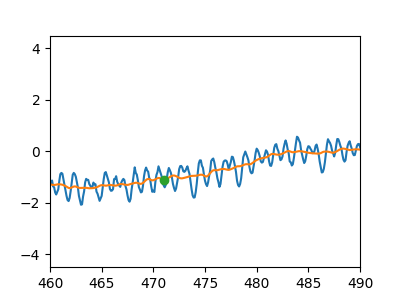

In [13]:
plt.figure(figsize=[4, 3])
plt.plot(data['time(us)'], data['ch6'])
# zoom in the below figure, and change the parameter n of smoother
plt.plot(data_f['time(us)'], smoother(data_f['data'], n=30))
plt.plot(471, floating_potential_smoothed(240828, 7, 6, 471), 'o')
plt.xlim(460, 490)